# Simon's Algorithm
<hr></hr>

[Simon's algorithm](https://en.wikipedia.org/wiki/Simon%27s_problem), introduced by Daniel R. Simon in 1994, corresponded to the first proposal of a quantum algorithm that solves a problem **exponentially** faster than the best known classical approach. [[Simon94]](https://epubs.siam.org/doi/pdf/10.1137/S0097539796298637). 

Even though the problem solved by this algorithm (dubbed Simon's problem) isn't of any practical relevance, its discovery laid the foundation for what would become Shor's algorithm, which is one of the very few quantum algorithms with a proven advantage for a real-world application.

<a name="back1"></a> Simon's problem is similar to the Bernstein-Vazinari problem in that we are tasked with finding a secret string $s$. However, the function that encodes $s$ is different[$^*$](#footnote1). In Simon's problem, we are given a function that takes an $n$-bit input $x$ and produces an $n$-bit output $f(x)$ (i.e., $f: {0, 1}^n \longmapsto {0, 1}^n$) where we are promised that $f(x) = f(s \oplus x).$ Here, $s$ is an $n$-bit string different from $0$, and $\oplus$ denotes the bitwise XOR (addition modulo-2) operation:

$$ s \oplus x = \underbrace{s_{n-1} \oplus x_{n-1}}_{(n-1)^{\text{th}} \text{ bit}} \dots \underbrace{s_{1} \oplus x_{1}}_{1^{\text{st}} \text{ bit}} \, \underbrace{s_{0} \oplus x_{0}}_{0^{\text{th}} \text{ bit}} .$$

This condition then generates a function for which two values of $x$ take the same value of $f(x)$ (i.e., the function is two-to-one). For example, given the string $s = 110$ we can have a function $f: \{0, 1\}^3 \longmapsto \{0, 1\}^3$, with the following mapping:

$$
\begin{split}
\begin{aligned}
f(000) &= 011
\\
f(001) &= 100
\\
f(010) &= 010
\\
f(011) &= 111
\\
f(100) &= 010
\\
f(101) &= 111
\\
f(110) &= 011
\\
f(111) &= 100
\end{aligned}
\end{split}
$$

Notice how, for example, for $x = 001$ and $x = (110 \oplus 001) = 111,$ we obtain the same $f(x) = 100.$ 

It is worth noting that, for the purpose of Simon's problem, the the value that $f(x)$ takes for each individual $x$ is completely arbitrary as long as the condition $f(x) = f(s \oplus x)$ is met.

Let's now use python to generate an arbitrary function $f(x)$ for every possible value of $x$ given a string $s$:

In [12]:
import numpy as np

In [13]:
def fx_simon(s_int, n):
    fx_lst = [0]*2**n
    x_used = []
    fx_avail = list(range(2**n))
    
    for x_int in range(2**n):
        if x_int in x_used: continue

        x_pair = s_int ^ x_int
        x_used.extend((x_int, x_pair))
        
        # pick random f(x) value and remove from available list
        fx_int = np.random.choice(fx_avail)
        fx_avail.remove(fx_int)
        
        # assign f(x) value to x and s⊕x
        fx_lst[x_int] = fx_int
        fx_lst[x_pair] = fx_int
        
    return fx_lst

In [14]:
s = '1101'          # String (pick value different from all-zeros string).
n = len(s)
s_int = int(s, 2)

fx_lst = fx_simon(s_int, n)

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')

for x_int, fx_int in enumerate(fx_lst):
    x = np.binary_repr(x_int,n)
    fx = np.binary_repr(fx_int,n)
    
    print(x, ' ', fx)

Outcomes for s = 1101

x      f(x)
0000   0110
0001   1111
0010   0001
0011   1001
0100   1011
0101   1100
0110   1010
0111   1110
1000   1100
1001   1011
1010   1110
1011   1010
1100   1111
1101   0110
1110   1001
1111   0001


Rerunning the cell above will result different values of $f(x)$ (picked at random) for each corresponding $x$. However, the condition $f(x) = f(s \oplus x)$ is always fulfilled.

## 1.1 Classical Approach

To solve Simon's problem classically, we have to evaluate the function $f(x)$ for different values of $x$ until we get a repeated output. If the values of $x$ for which we get the repeated outcome are the pair $\{a, b\},$ we then have $f(a) = f(b).$ Now, since $f(x) = f(s \oplus x)$ for all values of $x,$ this implies that $b = s \oplus a$. We can then find $s$  by taking the **XOR** with $a$ on both sides of this expression:

$$ 
\begin{aligned}
b &= s \oplus a
\\
\\
b \oplus a &= (s \oplus a) \oplus a
\\
\\
b \oplus a &= s \oplus (a \oplus a)
\\
\\
b \oplus a &= s.
\end{aligned}
$$

This equality holds because taking the bitwise **XOR** of any number with itself is always zero (i.e., $a \oplus a = 0$).

So, if we get very lucky, it takes only $2$ tries to find repeated outcomes that allows us to extract $s.$ However, since for a string of length $n$ we can have $2^n = 2^{n-1}$ different inputs for which there are $2^n/2$ corresponding $f(x)$ values (since $f(x)$ is two-to-one), it can take up to $2^{n-1} + 1$ tries to find the inputs for two matching outputs.

The function $f(x)$ for Simon's problem can be encoded in a unitary $U_f$ is a similar fashion to what we did in the Deutsch-Jozsa and Bernstein-Vazirani problems:

<img src="images/04_03_01_simons_bb.png" align = "center" width="650"/>

Here, the top $n$ qubits (labeled $|x\rangle$) correspond to the function input, and the bottom $n$ qubits produce the output $|f(x)\rangle$ when $|y\rangle = |0\rangle^{\otimes n}.$

Let's now create a python function that naïvely encodes the $f(x) = f(s \oplus x)$ condition into $U_f$ (details on this and a more efficient implementation are discussed in section 1.3).

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [16]:
def black_box(n):
    # Black box of Simon's problem using naïve implementation.
    # It encodes it each product element from a sum of products asan MCX gate.
    s_int = np.random.randint(1, 2**n)
    s = np.binary_repr(s_int, n)
    
    fx_controls = [[] for _ in range(n)]
    fx_lst = fx_simon(s_int, n)
    
    # Iterate over fx_list where each index is x, value is integer value of fx
    # and find the control values for each fx_i that evaluates to 1.
    for x_int, fx in enumerate(fx_lst):
        for bit, fx_bit in enumerate(reversed(np.binary_repr(fx, n))):
            if fx_bit == '1':
                fx_controls[bit].append(x_int)
    
    qc_bb = QuantumCircuit(2*n, name='Black Box')
    for i, controls in enumerate(fx_controls):
        for int_ctrl_state in controls:
            ctrl_state = np.binary_repr(int_ctrl_state,n)
            qc_bb.mcx(list(range(n,2*n)),i,ctrl_state=ctrl_state)
        qc_bb.barrier()
        
    return qc_bb, s

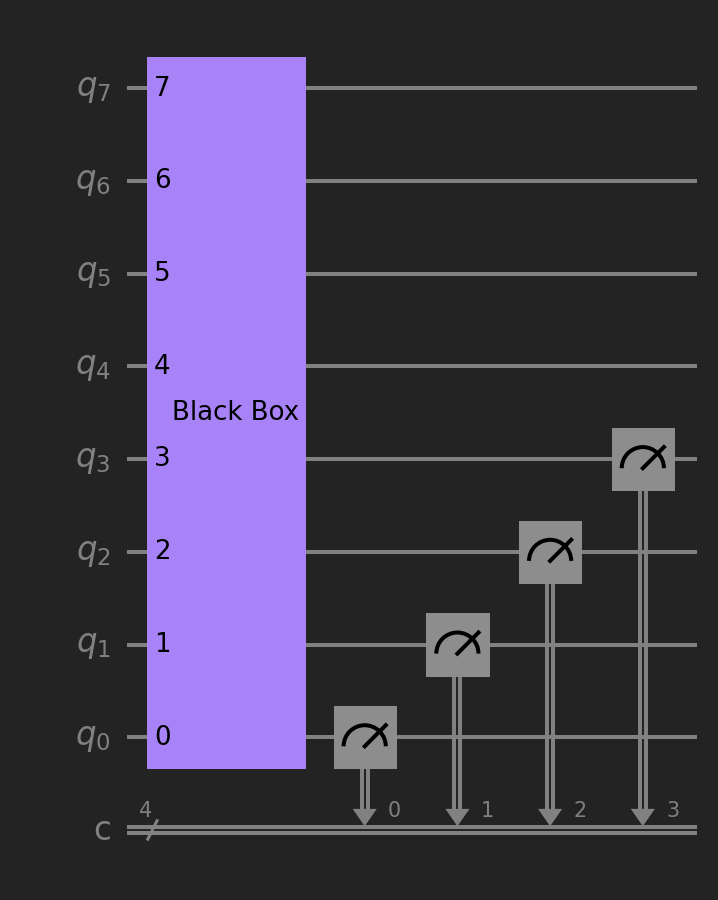

In [17]:
# Draw example circuit to solve B-V's problem classically (n = 4, x = 0000)
n = 4
bb, _ = black_box(n)

qc = QuantumCircuit(2*n,n)
qc.append(bb,range(2*n))
qc.measure(range(n),range(n))
qc.draw()

We can now try each possible input $x$ and check that, for the encoded string $s$, our unitary $U_f$ does correctly return the expected outputs:

In [18]:
# Go over every input and output

n = 3                        # String length
bb, s = black_box(n)         # Generate black box and secret string
fx_meas = {}                 # Dict where keys are measured fx and values are corresponding x

simulator = AerSimulator()

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')
for x_int in range(2**n):
    
    x = np.binary_repr(x_int, n)
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation to get f(x) outcome
    fx = job.result().get_memory()[0]
    
    print(x, ' ', fx)

Outcomes for s = 111

x     f(x)
000   110
001   000
010   001
011   010
100   010
101   001
110   000
111   110


Let us now pick different values of $x$ until we find two matching values of $f(x).$ Once found, we can then extract the randomly encoded secret string $s$ by taking the **XOR** between the inputs of the corresponding matching outputs:

In [19]:
n = 4                        # String length
bb, s = black_box(n)         # Generate black box and secret string

fx_meas = {}                  # Dictionary to store string extracted from f(x) and the corresponding value of x
match = False                 # Has a match been found?
x_avail = list(range(2**n))   # List with all possible x values to try
n_tries = 0

while not match:
    
    # pick x at random
    x_int = np.random.choice(x_avail)
    x_avail.remove(x_int)
    x = np.binary_repr(x_int, n)
    
    # evaluate Uf for selected x
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
        
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)
    fx = job.result().get_memory()[0]
    
    n_tries += 1
    
    if fx in fx_meas:
        s_out = np.binary_repr(x_int ^ int(fx_meas[fx], 2), n)
        match = True
    else:
        fx_meas[fx] = x
        
print(f'secret string: {s}')
print(f'extracted string: {s_out}')
print(f'number of tries: {n_tries} (out of {int(2**n/2)} possible outputs)')

secret string: 1101
extracted string: 1101
number of tries: 3 (out of 8 possible outputs)


Calculating the probability of classically finding a secret string of length $n$ after a certain number of tries $r$, is akin to solving the [birthday paradox problem](https://en.wikipedia.org/wiki/Birthday_problem), but where the sample space changes as the number of sampled $f(x)$ values increases:

$$ \mathbb{P}_{\text{success}} =  1- \prod_{k=0}^{r-1}\frac{2^n - 2 k}{2^n - k}$$

With this expression we can find that, for a total of $2^n$ possible values of $x$, it takes roughly $ r \sim \sqrt{2^{n}} = 2^{n/2}$ tries to find a match for $f(x)$ with probability larger than $50 \%$ (when $n$ is large). This means that, in a classical approach, the number of tries needed to successfully find $s$ with high probability grows **exponentially** with the length of the string $n.$ 

The plot below shows the simulation result for the probability of finding a secret string of length $n = 5$ after a certain number of tries $r:$
<img src="images/04_03_02_classical_probs.png" align = "center" width="520"/>

It can be seen that only after $r = 6$ tries, the probability of success is over $50 \%,$ which is close to the expectation of requiring a value larger than $2^{5/2} \approx 5.66.$

## 1.2 Quantum Approach

In contrast to the Deutsch-Jozsa and Bernstein-Vazirani algorithms (which yield a solution in single try), Simon's algorithm requires multiple accesses to the unitary $U_f$ in order to determine the secret string $s.$ However, unlike the classical approach we described above (for which we need a number of queries that grows exponentially with $n$), Simon's algorithm only requires an average number of calls to $U_f$ that grows linearly with $n.$ We will also see that, in contrast to the previous quantum algorithms, Simon's algorithm requires a classical post-processing step, where the measurement outcomes of multiple quantum circuit runs are used to compute $s.$

### 1.2.1 Quantum Circuit

The quantum circuit utilized in Simon's algorithm is similar to that of the Deutsch-Jozsa and Bernstein-Vazinari algorithms in that we place the top qubits $|q\rangle$ in superposition, apply $U_f,$ and then perform interference. 

<img src="images/04_03_03_simon.png" align = "center" width="520"/>

However, the circuit is different in that we do not prepare the bottom qubits $|p\rangle$ in an eigenstate of $U_f$ to perform phase kickback. Instead, we initialize them in the all-zeros state $|0\rangle^{\otimes n}$ and measure them right after the function evaluation takes place.

To understand the reasoning for this approach, lets analyze the circuit step by step for an arbitrary number of bits $n$. In [section 1.2.3](#1.2.3-Numerical-Example) we will go over a concrete example to clarify the process.

0. Initialize both qubit registers in the all-zeros state: 

$$ |\psi\rangle_0 = |q\rangle \otimes |p\rangle = |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n} $$

1. Place top qubits $|q\rangle$ in an equal superposition:

$$ 
\begin{aligned}
|\psi\rangle_1 &= \text{QHT}_n |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n} 
\\
\\
|\psi\rangle_1 &=  \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \right) \otimes |0\rangle^{\otimes n}; \; N = 2^n.  
\end{aligned}
$$

2. Evolve the state over $U_f$: 

$$ 
\begin{aligned}
|\psi\rangle_2 &= U_f |\psi\rangle_1
\\
\\
|\psi\rangle_2 &=  \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \otimes |f(x)\rangle.
\end{aligned}
$$

Here, $|\psi\rangle_2$ is a superposition state over all possible $|x\rangle$ values and their corresponding $|f(x)\rangle$. Now, since our function meets the condition $f(x) = f(s \oplus x),$ we know that every state $|x\rangle$ will have a corresponding $|s \oplus x\rangle$ that shares the same $|f(x)\rangle.$ Therefore, we can rewrite the expression above as:

$$ |\psi\rangle_2 =  \frac{1}{\sqrt{N}} \sum_{x \in S} \big( |x\rangle + |s \oplus x\rangle \big) \otimes |f(x)\rangle, $$

where $S$ is a set with half of the values $x$ can take (which depends on the string $s$).

3. Next, we measure the bottom register $|p\rangle,$ which will cause the superposition state $|\psi\rangle_2$ to be projected onto a state with a **single value** of $f(x).$ Let's call this state $|f(a)\rangle,$ where $a$ is some arbitrary value of $x.$ This will leave the top register $|q\rangle$ in a superposition of the **two states** that evaluate to the same $f(a)$:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|a\rangle + |s\oplus a\rangle \big) \otimes |f(a)\rangle .$$

For the remaining of the analysis, we can drop the state of the bottom register, leaving us with $ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \left(|a\rangle + |s\oplus a\rangle \right).$

4. We perform interference by applying the $\text{QHT}$ to the top register:

$$ 
\begin{aligned}
|\psi\rangle_4 &= \text{QHT}_n|\psi\rangle_3
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2}} \big(\text{QHT}_n|a\rangle + \text{QHT}_n|s\oplus a\rangle \big)
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2}} \left(\frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{a \cdot z} |z\rangle + \frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{(s \oplus a) \cdot z} |z\rangle \right)
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2 N}} \sum_{z = 0}^{N - 1} \left[ (-1)^{a \cdot z} + (-1)^{(s \oplus a)\cdot z} \right] |z\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2 N}} \sum_{z = 0}^{N - 1} (-1)^{a \cdot z} \left[1 + (-1)^{s \cdot z} \right] |z\rangle
\end{aligned}
$$

If we now focus on the probability amplitude expression inside the square brackets, we see that we have two possibilities:

- if $(s \cdot z) = 1,$ then $\left[1 + (-1)^{s \cdot z} \right] = 0, $
- if $(s \cdot z) = 0,$ then $\left[1 + (-1)^{s \cdot z} \right] = 2 .$

What this means is that, all the $|z\rangle$ terms in the summation for which the dot product between $s$ and $z$ is $1$, vanish. This leaves us with a state where only the terms for which $s \cdot z = 0$ survive:

$$ |\psi\rangle_4 = \frac{2}{\sqrt{2 N}} \sum_{\; z | (s \cdot z = 0)} (-1)^{a \cdot z} |z\rangle. $$

Here it is worth noting that, regardless of the value of the string $s$, the expression $s \cdot z = 0$ always holds for $z = 0$. Therefore, one of the terms that always remains is the all-zeros string $|z\rangle = |0\rangle^{\otimes n}.$ As a matter of convenience, we can pull this term out from the summation to make this explicit:

$$ |\psi\rangle_4 = \frac{1}{\sqrt{N/2}}\Big(|0\rangle^{\otimes n} + \sum_{\; z | (s \cdot z = 0), \\ \; \text{and } z \neq 0} (-1)^{a \cdot z} |z\rangle \Big). $$

5. The final step in the circuit is to measure state $|\psi\rangle_4$, which produces one of two types of outcomes:

- With probability $\left|\frac{1}{\sqrt{N/2}}\right|^2 = \frac{2}{N},$ we measure the all-zeros string $|0\rangle^{\otimes n}.$
- With probability $1 - \frac{2}{N},$ we measure some other state $|z\rangle$ for which the equation $s \cdot z = 0$ holds.

The first case is considered a "failed" attempt since it gives us no information whatsoever about the string $s.$ This means that, if we execute the circuit and measure $z = 0 \dots 00,$ we need to re-run the circuit.

The second case, on the other hand, provides us with a classical binary string $z = z_{n-1} ... z_1 z_0$ that meets the condition:

$$ 
\begin{aligned}
s \cdot z &= z_{n-1} s_{n-1} \oplus \dots \oplus z_{1} s_{1} \oplus z_{0} s_{0} = 0.
\end{aligned}
$$

This basically corresponds to a linear equation (modulo 2), where each $z_i$ is a coefficient equal to $0$ or $1,$ and each $s_i$ is an unknown. We can then execute Simon's quantum circuit several times to extract different values of $z$ that allow us to form a system of $n-1$ linearly-independent equations:

$$ 
\begin{aligned}
z_{n-1}^{(1)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(1)} s_{1} \oplus z_{0}^{(1)} s_{0} = 0
\\
\\
z_{n-1}^{(2)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(2)} s_{1} \oplus z_{0}^{(2)} s_{0} = 0
\\
&\vdots
\\
z_{n-1}^{(n-1)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(n-1)} s_{1} \oplus z_{0}^{(n-1)} s_{0} = 0.
\end{aligned}
$$

Here, the superscripts $j$ (in $z^{(j)}$) are used to represent the different $z$ strings we measure from executing the quantum circuit. Solving this system of equations gives us as a solution the $n$ bits of $s.$

So what we need is a procedure that, a) verifies that every measured $z$ is linearly-independent from the previous values, b) stores every of these $z$ values until we have $n-1$ results and, c) solves the resulting linear system of equations. Let's cover these steps in more detail in the next section.

### 1.2.2 Classical Post-Processing

From the explanation above, it is clear that Simon's algorithm requires a combination of quantum and classical steps. As a matter of fact, the flow chart below shows that the quantum circuit is only a portion of a larger hybrid process:

<img src="images/04_03_04_full_simon.png" align = "center" width="900"/>

Let's go over each of the steps:

1. The algorithm starts by checking if a value `k` (which represents the number of stored `z` outputs) is already equal to `n - 1`. This is the minimum number of linearly-independent equations required to find the `n` bits of `s`.

2. If the condition above is **not** met, Simon's circuit is executed to extract a new output `z`.

3. The next step is to check if this new output is **not** the all-zeros string, **and** is **not** already in the list of stored values `z_lst`. If these conditions are met, the algorithm proceeds. If it fails, the circuit must be rerun.

4. Next, it must be verified if `z` is linearly-independent from all previous values stored in `z_lst` (more on this below). If not, the circuit must be re-executed.

5. If step 4 passes, `z` is stored in `z_lst`. All steps above must be repeated until `k` is equal to `n - 1`.

6. Once all necessary values of `z` are available, the algorithm proceeds to solve the linear system of equations and find `s`.

Steps 1, 2, and 3 were described in detail in the previous section, so we can now focus on the classical post-processing steps involved in finding the linearly-independent values and solving the system of equations.

Let's start by first analyzing the case where, instead of checking if every new $z$ is linearly independent from the previous ones, we collect $m$ unique $z$ outputs, with $m$ is much larger than $n-1$. In other words, we skip step 4 altogether and collect many samples of $z$ in the hope that $n - 1$ will be linearly independent. Now, even if some of our $z^{(j)}$ samples are not linearly independent, we know that each of them still meet the condition $z^{(j)} \cdot s = 0: $

$$ z_{n-1}^{(j)} s_{n-1} \oplus \dots \oplus z_{1}^{(j)} s_{1} \oplus z_{0}^{(j)} s_{0} = 0. $$

We can rewrite the equation above as the dot product (modulo 2) of two binary vectors $\vec{z}^{(j)}$ and $\vec{s},$ where their entries are the bits of $z$ and $s$, respectively: $\vec{z}^{(j)} \cdot \vec{s} = 0 .$ Written in vector form:

$$ 
\begin{aligned}
\begin{bmatrix} z_{0}^{(j)} & z_{1}^{(j)} & \dots & z_{n-1}^{(j)} \end{bmatrix} \begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} &= 0
\end{aligned}
$$

We can then organize the $m$ different equations by stacking each $\vec{z}^{(j)}$ as rows in a matrix:

$$
\begin{bmatrix}
z_{0}^{(1)} & z_{1}^{(1)} & \dots & z_{n-1}^{(1)} \\
z_{0}^{(2)} & z_{1}^{(2)} & \dots & z_{n-1}^{(2)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(n-1)} & z_{1}^{(n-1)} & \dots & z_{n-1}^{(n-1)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(m)} & z_{1}^{(m)} & \dots  & z_{n-1}^{(m)}
\end{bmatrix}
\begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} = 
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

This expression is of the form $Z \vec{s} = \vec{0},$ which is convenient because it allows us to find the unknown vector $\vec{s}$ by computing the [kernel](https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Representation_as_matrix_multiplication) of the matrix $Z.$ The kernel is nothing other than the group of vectors that, when multiplied by that matrix, result in the all-zeros vector. 

The first step to computing the kernel of $Z$, is to express the matrix in what is known as its [reduced row echelon form (RREF)](https://en.wikipedia.org/wiki/Row_echelon_form#Reduced_row_echelon_form) through [Gauss-Jordan elimination](https://en.wikipedia.org/wiki/Gaussian_elimination#Gauss–Jordan_elimination). Here we won't focus on the details of how this is done; all we need to know is that, if our $m$ collected samples of $z$ contain $n - 1$ values that are linearly-independent, the RREF of $Z$ will be a matrix where the first $n-1$ rows correspond to a set of binary basis vectors $\vec{\zeta}^{(j)},$ and the remaining $ m - (n - 1) $ rows are all $0:$

$$
\begin{bmatrix}
z_{0}^{(1)} & z_{1}^{(1)} & \dots & z_{n-1}^{(1)} \\
z_{0}^{(2)} & z_{1}^{(2)} & \dots & z_{n-1}^{(2)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(n-1)} & z_{1}^{(n-1)} & \dots & z_{n-1}^{(n-1)} \\
\vdots      & \vdots      & \dots & \vdots \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(m)} & z_{1}^{(m)} & \dots  & z_{n-1}^{(m)}
\end{bmatrix}
\;\xrightarrow{\text{RREF}}\;
\begin{bmatrix}
\zeta_{0}^{(1)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
\zeta_{0}^{(2)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
\vdots          & \vdots          & \ddots & \vdots \\
\zeta_{0}^{(n-1)} & \zeta_{1}^{(n-1)} & \dots & \zeta_{n-1}^{(n-1)} \\
0 & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 0
\end{bmatrix}
$$

In the end, the basis vectors $\vec{\zeta}^{(j)}$ are what we really need to solve for $\vec{s}$ since they not only satisfy $\zeta \cdot s = 0$, but are also guaranteed to be all linearly independent.

Now selecting an optimal value for $m$ can be complicated because, if we pick it to be too small, there is a chance that we will not obtain the $n - 1$ linearly-independent values of $z$ we need to solve the system of equations. On the other hand, if we pick it too large, we end up with several linearly-**dependent** values of $z$, which do not provide us any additional basis vectors $\vec{\zeta}.$ So what we can do, is compute the basis vectors on the fly. Every time we sample a new $z$ from our circuit, we perform Gaussian elimination. If the process results in a new basis vector, we store it; if not, we execute the circuit again to obtain a new $z$ and repeat the process until we have the $n - 1$ basis vectors we need. These are basically steps 4 and 5, so all we have left is to perform step 6, which entails solving for $\vec{s}$ in the vector equation $Z\vec{s} = \vec{0}$ via back-substitution, but where we replace the matrix $Z$ with its corresponding RREF:

$$
\begin{bmatrix} \zeta_{0}^{(1)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
                \zeta_{0}^{(2)} & \zeta_{1}^{(2)} & \dots & \zeta_{n-1}^{(2)} \\
                \vdots & \vdots & \ddots & \vdots \\
                \zeta_{0}^{(n-1)} & \zeta_{1}^{(n-1)} & \dots & \zeta_{n-1}^{(n-1)} \end{bmatrix} 
\begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} = 
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} .
$$

Let's now take a look at a concrete numerical example of the full algorithm to get a better understanding of how each step works. 

### 1.2.3 Numerical Example

Let's start by assuming that we are given access to a unitary $U_f$ which encodes a function $f(x).$ We are promised that function satisfies the condition for Simon's problem $f(x) = f(s \oplus x)$ for a secret string $s = 1010,$ and has the following input/output relation:

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
x & 0000 & 0001 & 0010 & 0011 & 0100 & 0101 & 0110 & 0111 & 1000 & 1001 & 1010 & 1011 & 1100 & 1101 & 1110 & 1111 \\
\hline
f(x) & 1001 & 1010 & 1000 & 1011 & 0111 & 0011 & 0110 & 1110 & 1000 & 1011 & 1001 & 1010 & 0110 & 1110 & 0111 & 0011 \\ 
\hline
\end{array}
$$

#### Quantum Circuit Analysis

Since $x$ and $f(x)$ encode 4 bits each, the unitary $U_f$ that encodes the function (and therefore, our quantum circuit) must have 8 qubits total.

0. Initialize the circuit qubits in the all-zeros state:

$$ |\psi\rangle_0 = |0000\rangle \otimes |0000\rangle .$$

1. Apply $\text{QHT}$ to place top register in a uniform superposition:
$$
\begin{aligned}
|\psi\rangle_1 &=  \left( \frac{1}{\sqrt{2^4}} \sum_{x = 0}^{2^4 - 1} |x\rangle \right) \otimes |0000\rangle
\end{aligned}
$$

writing out each term explicitly:

$$
\begin{aligned}
|\psi\rangle_1  =  \frac{1}{4} \big(
&|0000\rangle + |0001\rangle + |0010\rangle + |0011\rangle \, + \\
&|0100\rangle + |0101\rangle + |0110\rangle + |0111\rangle \, + \\
&|1000\rangle + |1001\rangle + |1010\rangle + |1011\rangle \, + \\
&|1100\rangle +  |1101\rangle + |1110\rangle + |1111\rangle 
\big) \otimes |0000\rangle .
\end{aligned}
$$

2. Evolve the state through $U_f,$ which basically pairs up each $|x\rangle$ with its corresponding $|f(x)\rangle .$

$$
\begin{aligned}
|\psi\rangle_2  = \frac{1}{4} \big(
&|0000\rangle|1001\rangle + |0001\rangle|1010\rangle + |0010\rangle|1000\rangle + |0011\rangle|1011\rangle \, + \\
&|0100\rangle|0111\rangle + |0101\rangle|0011\rangle + |0110\rangle|0110\rangle + |0111\rangle|1110\rangle \, + \\
&|1000\rangle|1000\rangle + |1001\rangle|1011\rangle + |1010\rangle|1001\rangle + |1011\rangle|1010\rangle \, + \\ &|1100\rangle|0110\rangle + |1101\rangle|1110\rangle + |1110\rangle|0111\rangle + |1111\rangle|0011\rangle \big) .
\end{aligned}
$$

3. Measure bottom register, which projects the state onto a single value $|f(a)\rangle,$ and the top register onto a superposition of $|x\rangle$ and $|s \oplus x\rangle .$ Let's assume that, after the first execution, the measured value was $f(a) = 1011,$ resulting in the state:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|0011\rangle + |1001\rangle \big) \otimes |1011\rangle .$$

4. Apply $\text{QHT}$ on the top register to perform interference:

$$ 
\begin{aligned}
|\psi\rangle_4 = \frac{1}{\sqrt{8}} \big(
&|0000\rangle - |0001\rangle + |0100\rangle - |0101\rangle \, - \\ 
&|1010\rangle + |1011\rangle - |1110\rangle + |1111\rangle \big) .
\end{aligned}
$$

At this point it is worth pausing to highlight that, when we rerun the circuit, in step 3 we likely measure a different value of $f(x)$. However, the superposition we obtain in step 4 is always composed by the elements, just with different relative phases! This is because the algorithm is designed to always return the states $|z\rangle$ that meet the condition $s \cdot z = 0.$ For example, let's assume that after a second run we get the following state after step 3:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|0111\rangle + |1101\rangle \big) \otimes |1110\rangle .$$

Applying the $\text{QHT}$ on the top register of this state gives us:

$$ 
\begin{aligned}
|\psi\rangle_4 = \frac{1}{\sqrt{8}} \big(
&|0000\rangle - |0001\rangle - |0100\rangle + |0101\rangle \, - \\ 
&|1010\rangle + |1011\rangle + |1110\rangle - |1111\rangle \big) .
\end{aligned}
$$

So, independent of what value of $f(x)$ we measure, the state we get in step 4 is **always** a superposition of the same components: $\{|0000\rangle,$ $|0001\rangle,$ $|0100\rangle,$ $|0101\rangle,$ $|1010\rangle,$ $|1011\rangle,$ $|1110\rangle,$ $|1111\rangle \}.$

5. As the last step in the quantum circuit, we measure the top register which will result in either:

- The string $z = 0000$ with probability $|\frac{1}{\sqrt{8}}|^2 = \frac{1}{8},$ which gives us no information about the secret string $s.$
- A $z$ string from the list $\{0001,$ $0100,$ $0101,$ $1010,$ $1011,$ $1110,$ $1111\}$ with probability $\frac{7}{8},$ which we can use in the classical post-processing steps to extract $s$.

#### Classical Processing Analysis



In [31]:
int('1101',2)

13

In [32]:
from qiskit.quantum_info import Statevector
qc = QuantumCircuit(4)
qc.prepare_state(1/np.sqrt(2)*(Statevector.from_int(7,2**4)+Statevector.from_int(13,2**4)),range(4))
qc.h(range(4))
Statevector(qc)

<IPython.core.display.Latex object>

Assuming our secret string $s$ has $n = 3$ bits, then for our example we have:

$$ |\psi\rangle_0 = |000\rangle \otimes |000\rangle $$

In the case of our 3 qubit example this results in:

$$ |\psi\rangle_1 = \frac{1}{\sqrt{2^3}}\left(|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle \right) \otimes |000\rangle $$

## Footnotes

<a name="footnote1"></a><span style="font-size: smaller;">$^*$The definition of Simon's problem is actually broader than what is described above. More generally, Simon's problem considers an $n$ to $m$ function $f: \{0, 1\}^n \longmapsto \{0, 1\}^n, \, m \geq n,$ which meets the condition $f(x) = f(s \oplus x).$ The function is either one-to-one (when $s$ is the all-zeros string) or two-to-one (when $s$ is any other string). Simon's decision problem consists of finding which of these two types of function $f(x)$ is. Simon's no-decision problem consists in finding what the bit-string $s$ is, which is what is described in this chapter for the case in which $m = n.$ ([go back](#back1))</span>

In [39]:
n = 5
s = np.random.randint(1,2**n)
print(np.binary_repr(s,n),'\n')

c = 0

for z in range(2**n):
    dot = s ^ z
    not_dot = dot ^ 2**n-1
    c += not_dot.bit_count() % 2
    
print(c)

11001 

16


In [5]:
def gen_basis(stream, x):
    """
    stream : iterable yielding lists/tuples of 0/1
    x      : number of independent vectors to collect

    Returns:
        basis : list of independent vectors (in row-echelon form)
    """
    basis = []

    for v in stream:
        v = list(v)

        # eliminate using existing pivots
        for b in basis:
            pivot = b.index(1)
            if v[pivot] == 1:
                v = [(vi ^ bi) for vi, bi in zip(v, b)]

        # check if zero
        if any(v):
            # normalize: make pivot the leftmost 1
            pivot = v.index(1)
            for i, b in enumerate(basis):
                if b[pivot] == 1:
                    basis[i] = [(bi ^ vi) for bi, vi in zip(b, v)]
            basis.append(v)

            if len(basis) == x:
                break

    return basis

In [6]:
stream = ([1,1,1], [0,0,1])
gen_basis(stream, 3)

[[1, 1, 0], [0, 0, 1]]

0101
1010
